In [ ]:
import pandas as _hex_pandas
import datetime as _hex_datetime
import json as _hex_json

In [ ]:
hex_scheduled = _hex_json.loads("false")

In [ ]:
hex_user_email = _hex_json.loads("\"example-user@example.com\"")

In [ ]:
hex_run_context = _hex_json.loads("\"logic\"")

In [ ]:
hex_timezone = _hex_json.loads("\"UTC\"")

In [ ]:
hex_project_id = _hex_json.loads("\"263929f6-ea30-49a4-86d2-7f4b5708720d\"")

In [ ]:
hex_project_name = _hex_json.loads("\"OSRT\"")

In [ ]:
hex_status = _hex_json.loads("\"\"")

In [ ]:
hex_categories = _hex_json.loads("[]")

In [ ]:
hex_color_palette = _hex_json.loads("[\"#4C78A8\",\"#F58518\",\"#E45756\",\"#72B7B2\",\"#54A24B\",\"#EECA3B\",\"#B279A2\",\"#FF9DA6\",\"#9D755D\",\"#BAB0AC\"]")

In [ ]:
# Install osrt

import os
os.environ["SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL"] = "True"
!pip install osrt

# Install gosdt
!pip install gosdt

  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.1/516.1 kB 9.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.1 MB/s eta 0:00:00
  Created wheel for sklearn: filename=sklearn-0.0.post12-py3-none-any.whl size=2179 sha256=6c9b0d25352f10c76e2a59dc64e494f614fac41d48f88f08514bc1b483e28e19
  Stored in directory: /home/hexuser/.cache/pip/wheels/2e/52/73/b1127c928e54b3d127adfb67b608d945d93a8ff571a4970535
Successfully built sklearn
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 10.4 MB/s eta 0:00:00 0:00:01


In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression

# Load the dataset
file_path = os.path.join(os.getcwd(), "Medicaid_Conditions_Binarized.csv")
df = pd.read_csv(file_path)

# Prepare the data
X = df.drop("target", axis=1)
y = df["target"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Get the p-values for the features
_, p_values = f_regression(X_train, y_train)

# Get the significant variables
significant_variables2 = X.columns[p_values < 0.05]

# Create a new dataframe with only the significant variables
significant_df = df[significant_variables2]

# Output the significant_df to a csv file
output_csv_path = os.path.join(os.getcwd(), "General_Disease_Significant.csv")
significant_df.to_csv(output_csv_path, index=False)

In [ ]:
# First attempt at fitting model
import pandas as pd
import numpy as np
import time
import pathlib
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score, balanced_accuracy_score

# Assuming compute_thresholds and OSRT are available in the current directory or a correct path.
from osrt.model.threshold_guess import compute_thresholds
from osrt.model.osrt import OSRT
from gosdt.model.gosdt import GOSDT
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

# read the dataset
# preprocess your data otherwise OSRT will binarize continuous feature using all threshold values.
df = pd.read_csv("General_Disease_Significant.csv")
X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values
h = df.columns[:-1]
X = pd.DataFrame(X, columns=h)

# guess thresholds (OPTIONAL) uncomment following lines if you want to speed up optimization
# NOTE: You should also evaluate accuracy on guessed data if you choose to guess thresholds
# GBRT parameters for threshold guesses
n_est = 40
max_depth = 1
X_opt, thresholds, header, threshold_guess_time = compute_thresholds(
    X, y, n_est, max_depth
)

X_train, X_test, y_train, y_test = train_test_split(
    X_opt, y, test_size=0.2, random_state=42
)

# X_train = X
# y_train = pd.DataFrame(y)
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

# train OSRT model
#config = {
#    "similar_support": False,
#    "feature_exchange": False,
#    "continuous_feature_exchange": False,
#    "regularization": 0.007,
#    "depth_budget": 6,
#    "model_limit": 1,
#    "time_limit": 0,
#    "metric": "L2",
#    "weights": [],
#    "verbose": False,
#    "diagnostics": True,
# }

config = {
    "similar_support": False,
    "regularization": 0.01,
}

#model = GOSDT(config)
model = OSRT(config)

model.fit(X_train, y_train)

print("evaluate the model, extracting tree and scores", flush=True)

# get the results of trained model
train_score = model.score(X_train, y_train)
n_leaves = model.leaves()
n_nodes = model.nodes()
time = model.time
depth = model.max_depth()


print("Model training time: {}".format(time))
print("Training Score: {}".format(train_score))
print("# of leaves: {}".format(n_leaves))
print("Depth: {}".format(depth))
print(model.tree)

# Test model
y_predict = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_predict)
test_r2 = r2_score(y_test, y_predict)
#acc_score = accuracy_score(y_test, y_predict)
#bal_acc_score = balanced_accuracy_score(y_test, y_predict)
#roc_score = roc_auc_score(y_test, y_predict)
print("Final MSE: {}".format(test_mse))
print("Final R2: {}".format(test_r2))
#print("Accuracy Score: {}".format(acc_score))
#print("Balanced Accuracy Score: {}".format(bal_acc_score))
#print("ROC AUC Score: {}".format(roc_score))

X_train: (23263, 6)
y_train: (23263,)
X_test: (5816, 6)
y_test: (5816,)
osrt reported successful execution
training completed. 1.413 seconds.
bounds: [0.309004..0.309004] (0.000000) normalized loss=0.239004, iterations=506
evaluate the model, extracting tree and scores
Model training time: 1.4129999876022339
Training Score: 0.005283407132066759
# of leaves: 7
Depth: 7
if Arthritis<=0.5 = 1 and Chronic Kidney Disease<=0.5 = 1 and Diabetes<=0.5 = 1 and Hyperlipidemia<=0.5 = 1 and Hypertension<=0.5 = 1 and Ischemic Heart Disease<=0.5 = 1 then:
    predicted class: 0.068312
    normalized loss penalty: 0.141
    complexity penalty: 0.01

else if Arthritis<=0.5 = 1 and Chronic Kidney Disease<=0.5 = 1 and Diabetes<=0.5 = 1 and Hyperlipidemia<=0.5 = 1 and Hypertension<=0.5 = 1 and Ischemic Heart Disease<=0.5 != 1 then:
    predicted class: 0.221716
    normalized loss penalty: 0.012
    complexity penalty: 0.01

else if Arthritis<=0.5 = 1 and Chronic Kidney Disease<=0.5 = 1 and Diabetes<=0.5 

In [ ]:
# -----CART-----
from math import sqrt
import time
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


df = pd.read_csv("Medicaid_Conditions_Binarized.csv")
X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values
h = df.columns[:-1]
X = pd.DataFrame(X, columns=h)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# best_depth=6
#cart_model = DecisionTreeClassifier(min_impurity_decrease=0.008)
cart_model = DecisionTreeRegressor(min_impurity_decrease=0.001)

start_time = time.time()
cart_model.fit(X_train, y_train)
elapsed_time = time.time() - start_time

y_test_pred = cart_model.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
rmse = sqrt(mse)
leaves = cart_model.get_n_leaves()
r2 = r2_score(y_test, y_test_pred)
#acc_score = accuracy_score(y_test, y_test_pred)
#bal_acc_score = balanced_accuracy_score(y_test, y_test_pred)
#roc_score = roc_auc_score(y_test, y_test_pred)
best_depth = cart_model.get_depth()

print(f"-----CART-----")
print(f"Depth: {best_depth}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"Number of Leaves: {leaves}")
print(f"R2: {r2}")
#print(f"Accuracy: {acc_score}")
#print(f"Balanced Accuracy: {bal_acc_score}")
#print("ROC AUC Score: {}".format(roc_score))
print(f"{elapsed_time:.5f}s elapsed during training")
print()


# -----Random Forest-----
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

# Initialize the RandomForestClassifier with current depth_limit
# best_depth=7
#rf_clf = RandomForestClassifier(min_impurity_decrease=0.008, random_state=42)
rf_clf = RandomForestRegressor(min_impurity_decrease=0.001,random_state=42)

start_time = time.time()
rf_clf.fit(X_train, y_train)
elapsed_time = time.time() - start_time

# Predict on the test set
y_test_pred = rf_clf.predict(X_test)

# Calculate the number of leaves
num_leaves = sum(tree.tree_.n_leaves for tree in rf_clf.estimators_)
mse = mean_squared_error(y_test, y_test_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test, y_test_pred)
#acc_score = accuracy_score(y_test, y_test_pred)
#bal_acc_score = balanced_accuracy_score(y_test, y_test_pred)
#roc_score = roc_auc_score(y_test, y_test_pred)
max_depth = list()
for tree in rf_clf.estimators_:
    max_depth.append(tree.tree_.max_depth)

print(f"-----Random Forest-----")
print(f"Depth: {sum(max_depth)/len(max_depth)}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"Number of Leaves: {num_leaves}")
print(f"R2: {r2}")
#print(f"Accuracy: {acc_score}")
#print(f"Balanced Accuracy: {bal_acc_score}")
#print("ROC AUC Score: {}".format(roc_score))
print(f"{elapsed_time:.5f}s elapsed during training")
print()


# -----XGBoost-----
from xgboost import XGBRegressor
from xgboost import XGBClassifier

# best_depth=3
xgb_clf = XGBRegressor(
    reg_lambda=0.01,
    #max_depth=best_depth,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",
)
#xgb_clf = XGBClassifier(
#    reg_lambda=0.008,
#    #max_depth=best_depth,
#    random_state=42,
#    use_label_encoder=False,
#    eval_metric="logloss",
# )

start_time = time.time()
xgb_clf.fit(X_train, y_train)
elapsed_time = time.time() - start_time

# Predict on the test set
y_test_pred = xgb_clf.predict(X_test)

# Get the number of leaves
# num_leaves = xgb_clf.get_booster().trees_to_dataframe()["Tree"].nunique()
num_leaves = len(xgb_clf.get_booster().trees_to_dataframe())
num_calc = (
    xgb_clf.get_booster().trees_to_dataframe()["Node"].nunique()
    * xgb_clf.get_booster().trees_to_dataframe()["Tree"].nunique()
)
mse = mean_squared_error(y_test, y_test_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test, y_test_pred)
#acc_score = accuracy_score(y_test, y_test_pred)
#bal_acc_score = balanced_accuracy_score(y_test, y_test_pred)
#roc_score = roc_auc_score(y_test, y_test_pred)

print(f"-----XGBoost-----")
print(f"Depth: {sum(max_depth)/len(max_depth)}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"Number of Leaves: {num_leaves}")
print(f"Number of Calcs: {num_calc}")
print(f"R2: {r2}")
#print(f"Accuracy: {acc_score}")
#print(f"Balanced Accuracy: {bal_acc_score}")
#print("ROC AUC Score: {}".format(roc_score))
print(f"{elapsed_time:.5f}s elapsed during training")
print()


# -----SVM-----
from sklearn.svm import SVR
from sklearn.svm import SVC

# Initialize the SVM classifier
svm_model = SVR()
#svm_model = SVC()

start_time = time.time()
svm_model.fit(X_train, y_train)
elapsed_time = time.time() - start_time

# Predict on the test set
y_test_pred = svm_model.predict(X_test)

mse = mean_squared_error(y_test, y_test_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test, y_test_pred)
#acc_score = accuracy_score(y_test, y_test_pred)
#bal_acc_score = balanced_accuracy_score(y_test, y_test_pred)
#roc_score = roc_auc_score(y_test, y_test_pred)
num_vectors = len(svm_model.support_vectors_)
num_calc = X_test.shape[0] * num_vectors

print(f"-----SVM-----")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")
#print(f"Accuracy: {acc_score}")
#print(f"Balanced Accuracy: {bal_acc_score}")
#print("ROC AUC Score: {}".format(roc_score))
print(f"# of Vectors: {num_vectors}")
print(f"# of Calculations: {num_calc}")
print(f"{elapsed_time:.5f}s elapsed during training")
print()


# -----Perceptron-----
from sklearn.linear_model import Perceptron

# Initialize the Perceptron model
perceptron = Perceptron()

# Train the model
start_time = time.time()
#perceptron.fit(X_train, y_train)
elapsed_time = time.time() - start_time

# Test the model
#y_test_pred = perceptron.predict(X_test)
#y_test_pred = perceptron.predict_proba(X_test)

# Calculate accuracy
mse = mean_squared_error(y_test, y_test_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test, y_test_pred)
#acc_score = accuracy_score(y_test, y_test_pred)
#bal_acc_score = balanced_accuracy_score(y_test, y_test_pred)
#roc_score = roc_auc_score(y_test, y_test_pred)
num_calc = X_test.shape[0] * X_train.shape[1]

print(f"-----Perceptron-----")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")
#print(f"Accuracy: {acc_score}")
#print(f"Balanced Accuracy: {bal_acc_score}")
#print("ROC AUC Score: {}".format(roc_score))
print(f"Number of Calcs: {num_calc}")
print(f"{elapsed_time:.5f}s elapsed during training")
print()


# -----Logistic Regression-----
from sklearn.linear_model import LogisticRegression

# Initialize the Perceptron model
log_reg = LogisticRegression(tol=0.008)

# Train the model
start_time = time.time()
#log_reg.fit(X_train, y_train)
elapsed_time = time.time() - start_time

# Test the model
#y_test_pred = log_reg.predict(X_test)
#y_test_pred = log_reg.predict_proba(X_test)

# Calculate accuracy
mse = mean_squared_error(y_test, y_test_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test, y_test_pred)
#acc_score = accuracy_score(y_test, y_test_pred)
#bal_acc_score = balanced_accuracy_score(y_test, y_test_pred)
#roc_score = roc_auc_score(y_test, y_test_pred)
num_calc = X_test.shape[0] * X_train.shape[1]

print(f"-----Logistic Regression-----")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R2: {r2}")
#print(f"Accuracy: {acc_score}")
#print(f"Balanced Accuracy: {bal_acc_score}")
#print("ROC AUC Score: {}".format(roc_score))
print(f"Number of Calcs: {num_calc}")
print(f"{elapsed_time:.5f}s elapsed during training")
print()

-----CART-----
Depth: 7
MSE: 0.0041864795048176945
RMSE: 0.06470301001358202
Number of Leaves: 8
R2: 0.8150061894804989
0.06850s elapsed during training

-----Random Forest-----
Depth: 6.98
MSE: 0.004186303795168794
RMSE: 0.06470165218268227
Number of Leaves: 798
R2: 0.8150139538078908
4.03794s elapsed during training

-----XGBoost-----
Depth: 6.98
MSE: 0.00048596708967255255
RMSE: 0.022044661251027484
Number of Leaves: 10528
Number of Calcs: 11900
R2: 0.978525894226368
7.68581s elapsed during training

-----SVM-----
MSE: 0.0038024532813058926
RMSE: 0.06166403555806166
R2: 0.8319756919813729
# of Vectors: 846
# of Calculations: 4920336
2.08740s elapsed during training

-----Perceptron-----
MSE: 0.0038024532813058926
RMSE: 0.06166403555806166
R2: 0.8319756919813729
Number of Calcs: 552520
0.00003s elapsed during training

-----Logistic Regression-----
MSE: 0.0038024532813058926
RMSE: 0.06166403555806166
R2: 0.8319756919813729
Number of Calcs: 552520
0.00003s elapsed during training



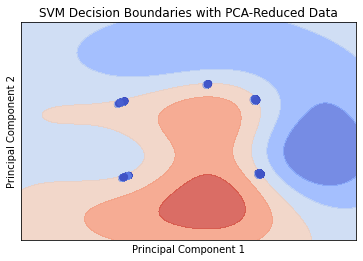

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization, using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Fit the model on the reduced data
svm_model.fit(X_pca, y)
#perceptron.fit(X_pca, y)
#log_reg.fit(X_pca, y)


# Create a grid to plot decision boundaries
h = 0.02  # step size in the mesh
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Predict class labels for the grid
Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])
#Z = perceptron.predict(np.c_[xx.ravel(), yy.ravel()])
#Z = log_reg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundaries
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot also the training points
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title("SVM Decision Boundaries with PCA-Reduced Data")
plt.show()

In [ ]:
# Hyperparameter search

def hyperParameterSearch(param_grid, X_train, X_test, y_train, y_test):
    print(param_grid)
    best_num_leaves = 10000
    best_r2 = 0
    best_mse = 10000
    best_params = []
    best_model = None
    for i in range(len(param_grid["depth_budget"])):
        for j in range(len(param_grid["regularization"])):
            depth_budget = param_grid["depth_budget"][i]
            regularization = param_grid["regularization"][j]
            params = {
            "similar_support": False,
            "regularization": regularization,
            "depth_budget": depth_budget,
            }

            # Print current list of params
            #print("Current params:")
            #print(params)

            model = OSRT(params)
            model.fit(X_train, y_train)

            # get the results of trained model
            n_leaves = model.leaves()
            #print("Current # of leaves: {}".format(n_leaves))

            # Test model
            predict = model.predict(X_test)
            r2 = r2_score(y_test, predict)
            mse = mean_squared_error(y_test, predict)
            #print("Current R2: {}".format(r2))
            #print("Current MSE: {}".format(mse))
            #print()

            if n_leaves <= best_num_leaves+3 and r2 > best_r2:
                best_params = {
                    "depth_budget": depth_budget,
                    "regularization": regularization
                }
                best_mse = mse
                best_r2 = r2
                best_num_leaves = n_leaves
                best_model = model
    return best_model, best_params, best_mse, best_r2, best_num_leaves

In [ ]:
# Perform K-fold validation
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score, balanced_accuracy_score
from osrt.model.threshold_guess import compute_thresholds
from gosdt.model.gosdt import GOSDT
from osrt.model.osrt import OSRT

# read the dataset
# preprocess your data otherwise OSRT will binarize continuous feature using all threshold values.
df = pd.read_csv("significant_variables3.csv")
X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values
h = df.columns[:-1]
X = pd.DataFrame(X, columns=h)

# guess thresholds (OPTIONAL) uncomment following lines if you want to speed up optimization
# NOTE: You should also evaluate accuracy on guessed data if you choose to guess thresholds
# GBRT parameters for threshold guesses
n_est = 40
max_depth = 1
X_opt, thresholds, header, threshold_guess_time = compute_thresholds(
    X, y, n_est, max_depth
)


# K Fold validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)


regularization_list = [0.0001,0.0005,0.001,0.005,0.01]

for regularization in regularization_list:
    list_mse = []
    list_leaves = []
    list_r2 = []
    list_depth = []
    results = []
    for train_index, test_index in kf.split(X_opt):
        X_train_kf, X_test_kf = X_opt.iloc[train_index], X_opt.iloc[test_index]
        y_train_kf, y_test_kf = y[train_index], y[test_index]

        config = {
            "similar_support": False,
            "regularization": regularization,
        }

        model = GOSDT(config)
        #model = OSRT(config)
        model.fit(X_train_kf, y_train_kf)
        y_test_pred_kf = model.predict(X_test_kf)

        mse = mean_squared_error(y_test_kf, y_test_pred_kf)
        leaves = model.leaves()
        #r2 = accuracy_score(y_test_kf, y_test_pred_kf)
        r2 = r2_score(y_test_kf, y_test_pred_kf)
        depth = model.max_depth()
        list_mse.append(mse)
        list_leaves.append(leaves)
        list_r2.append(r2)
        list_depth.append(depth)

    avg_mse = np.mean(list_mse)
    avg_leaves = np.mean(list_leaves)
    avg_r2 = np.mean(list_r2)
    avg_depth = np.mean(list_depth)
    results.append(
        {
            "avg_depth": avg_depth,
            "avg_mse": avg_mse,
            "avg_leaves": avg_leaves,
            "avg_r2": avg_r2
        }
    )

    # Display the results
    for result in results:
        print(f"Regularization: {regularization}")
        print(f"Average Depth: {result['avg_depth']}")
        print(f"Average MSE: {result['avg_mse']}")
        print(f"Average Number of Leaves: {result['avg_leaves']}")
        print(f"Average R2: {result['avg_r2']}")
        print(f"Accuracy: {acc_score}")
        print(f"Balanced Accuracy: {bal_acc_score}")
        print("ROC AUC Score: {}".format(roc_score))
        print(model.tree)


gosdt reported successful execution
training completed. 0.000/0.000/0.000 (user, system, wall), mem=0 MB
bounds: [0.004792..0.004792] (0.000000) loss=0.000000, iterations=26
gosdt reported successful execution
training completed. 0.000/0.000/0.000 (user, system, wall), mem=0 MB
bounds: [0.004792..0.004792] (0.000000) loss=0.000000, iterations=26
gosdt reported successful execution
training completed. 0.000/0.000/0.000 (user, system, wall), mem=0 MB
bounds: [0.004792..0.004792] (0.000000) loss=0.000000, iterations=26
gosdt reported successful execution
training completed. 0.000/0.000/0.000 (user, system, wall), mem=0 MB
bounds: [0.004785..0.004785] (0.000000) loss=0.000000, iterations=26
gosdt reported successful execution
training completed. 0.000/0.000/0.000 (user, system, wall), mem=0 MB
bounds: [0.004785..0.004785] (0.000000) loss=0.000000, iterations=26
Regularization: 0.0001
Average Depth: 3.0
Average MSE: 0.0
Average Number of Leaves: 3.0
Average R2: 1.0
Accuracy: 0.9936305732484

In [ ]:
correlation_matrix = df.corr()
correlation_matrix
plt.figure(figsize=(12, 10))
plt.title("Heatmap of Correlation Matrix")
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

plt.figure(figsize=(12, 10))
plt.title("Heatmap of Correlation Matrix")
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.savefig("correlation_matrix_heatmap.png")
plt.close()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

# Create a DataFrame from the provided data
algorithm_data = {
    "Algorithm": ["GOSDT", "CART", "Random Forest", "XGBoost"],
    "Test Accuracy": [0.805, 0.805, 0.820, 0.966],
    "ROC Score": [0.804, 0.805, 0.819, 0.956],
    "Training Time (secs)": [0.015, 0.003, 0.168, 0.158],
    "# of Leaves": [6, 8, 655, 3064],
    "Average Depth per Tree": [4, 4, 4, 4],
}
df = pd.DataFrame(algorithm_data)

# Define colors
pestle_colors = ["#6A5ACD", "#FF69B4", "#20B2AA", "#778899"]

# Function to save pie chart
def save_pie_chart(data, labels, title, filename):
    fig, ax = plt.subplots()
    ax.pie(
        data,
        labels=labels,
        autopct="%1.1f%%",
        startangle=140,
        colors=pestle_colors,
    )
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()


# Replace 'GOSDT' with 'OST' in the labels
labels = df["Algorithm"].replace("GOSDT", "OST")

# Test Accuracy
save_pie_chart(
    df["Test Accuracy"], labels, "Test Accuracy", "test_accuracy_pie_chart.png"
)

# ROC Score
save_pie_chart(df["ROC Score"], labels, "ROC Score", "roc_score_pie_chart.png")

# Training Time
save_pie_chart(
    df["Training Time (secs)"], labels, "Training Time", "training_time_pie_chart.png"
)

# Number of Leaves
save_pie_chart(
    df["# of Leaves"], labels, "Number of Leaves", "number_of_leaves_pie_chart.png"
)